In [1]:
#Cargar librerías necesarias para las actividades
import sqlite3
import pyodbc
import pandas as pd
import numpy as np
from datetime import datetime
import os

In [15]:
# Obtener el nombre del usuario y definir la ruta de la base de datos en Descargas
usuario = os.getlogin()
ruta_db = fr"C:\Users\{usuario}\Downloads\database\database.sqlite"

# Conectar a la base de datos
conn = sqlite3.connect(ruta_db)

# Obtener la lista de tablas en la base de datos
query_tablas = "SELECT name FROM sqlite_master WHERE type='table';"
tablas = pd.read_sql(query_tablas, conn)

# Mostrar las tablas disponibles
print("Tablas disponibles en la base de datos:")
display(tablas)  # Muestra la tabla en formato bonito

# Leer y mostrar los datos de cada tabla
for tabla in tablas["name"]:
    print(f"\nCargando datos de la tabla: {tabla}")
    df = pd.read_sql_query(f"SELECT * FROM {tabla}", conn)
    display(df.head())  # Muestra las primeras filas de la tabla

# Cerrar la conexión
conn.close()

Tablas disponibles en la base de datos:


,name
0,apicall
1,commerce



Cargando datos de la tabla: apicall


,date_api_call,commerce_id,ask_status,is_related
0,2024-10-21 18:31:16,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
1,2024-10-13 17:12:08,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
2,2024-12-23 01:02:06,Rh2k-J1o7-zndZ-cOo8,Successful,1.0
3,2024-07-11 07:24:35,GdEQ-MGb7-LXHa-y6cd,Successful,1.0
4,2024-06-28 11:43:52,Rh2k-J1o7-zndZ-cOo8,Successful,1.0



Cargando datos de la tabla: commerce


,commerce_id,commerce_nit,commerce_name,commerce_status,commerce_email
0,KaSn-4LHo-m6vC-I4PU,445470636,Innovexa Solutions,Inactive,innovexasolutions@microfitsof.com
1,Vj9W-c4Pm-ja0X-fC1C,452680670,NexaTech Industries,Active,nexatechindustries@gemaily.net
2,Rh2k-J1o7-zndZ-cOo8,198818316,QuantumLeap Inc.,Active,quantumleapinc.@gemaily.net
3,3VYd-4lzT-mTC3-DQN5,28960112,Zenith Corp.,Active,zenithcorp.@gemaily.net
4,GdEQ-MGb7-LXHa-y6cd,919341007,FusionWave Enterprises,Active,fusionwaveenterprises@microfitsof.com


## Análisis Exploratorio de datos

### Campos de la tabla commerce
**commerce_id**: Identificador único de comercio. Se encuentran 5 valores únicos de los Id's  
**commerce_nit**: NIT de comercio  
**commerce_name**: Nombre del comercio  
**commerce_status**: Estado del comercio (Activo / Inactivo)  
**commerce_email**: Correo relacionado del comercio

In [3]:
# Leer una tabla en un DataFrame
conn = sqlite3.connect(ruta_db)

table_commerce = pd.read_sql_query("SELECT * FROM commerce", conn)
#table_apicall["is_related"] = table_apicall["is_related"].astype(bool)

table_commerce.head()

,commerce_id,commerce_nit,commerce_name,commerce_status,commerce_email
0,KaSn-4LHo-m6vC-I4PU,445470636,Innovexa Solutions,Inactive,innovexasolutions@microfitsof.com
1,Vj9W-c4Pm-ja0X-fC1C,452680670,NexaTech Industries,Active,nexatechindustries@gemaily.net
2,Rh2k-J1o7-zndZ-cOo8,198818316,QuantumLeap Inc.,Active,quantumleapinc.@gemaily.net
3,3VYd-4lzT-mTC3-DQN5,28960112,Zenith Corp.,Active,zenithcorp.@gemaily.net
4,GdEQ-MGb7-LXHa-y6cd,919341007,FusionWave Enterprises,Active,fusionwaveenterprises@microfitsof.com


### Campos de la tabla apicall
**date_api_call**: Fecha en la que se hizo el llamado desde la API  
**commerce_id**: Identificador único del comercio. Se encuentran 5 valores únicos de los Id's  
**ask_status**: Respuesta del servicio (Successfull/No exitosa)  
**is_related**: Es un booleano, se hace transformación del tipo de datos

In [4]:
# Leer una tabla en un DataFrame
conn = sqlite3.connect(ruta_db)

sql="""
SELECT 
t1.date_api_call,  --Selecciona la fecha del llamado a la API de la tabla apicall
t2.commerce_name,  -- Seleccionar el nombre del comercio
t1.ask_status   --Selecciona el estado de la transacción
FROM apicall as t1  --Selecciona la tabla apicall
INNER JOIN commerce as t2 on t1.commerce_id=t2.commerce_id  --Cruza por el id del comercio con la tabla commerce
WHERE t2.commerce_status="Active"   -- Selecciona los comercios Activos
"""

df = pd.read_sql_query(sql, conn)

# Cambia el tipo de datos de la fecha de String a datetime
df['date_api_call'] = pd.to_datetime(df['date_api_call'], errors='coerce')

df.head()

,date_api_call,commerce_name,ask_status
0,2024-01-01 00:00:29,NexaTech Industries,Successful
1,2024-01-01 00:01:01,NexaTech Industries,Successful
2,2024-01-01 00:01:12,NexaTech Industries,Successful
3,2024-01-01 00:01:29,NexaTech Industries,Unsuccessful
4,2024-01-01 00:03:19,NexaTech Industries,Successful


In [5]:
# Extraer el año y el mes para evaluar la cantidad de registros por cada mes
df['año'] = df['date_api_call'].dt.year
df['mes'] = df['date_api_call'].dt.month

# Agrupar por año y mes y contar los registros
resultados = df.groupby(['año', 'mes']).size().reset_index(name='conteo')

# Mostrar el resultado
print(resultados)

     año  mes  conteo
0   2024    1  101411
1   2024    2   94974
2   2024    3  101534
3   2024    4   98489
4   2024    5  101831
5   2024    6   98255
6   2024    7  101842
7   2024    8  101589
8   2024    9   98590
9   2024   10  101664
10  2024   11   98393
11  2024   12  101328


In [6]:
columnas = ["commerce_name", "ask_status"]

# Obtiene el total general de registros
total_registros = len(df)

# Itera sobre las columnas seleccionadas y obtener los valores únicos con sus conteos y porcentajes
for columna in columnas:
    print(f"\nValores únicos y sus conteos en la columna: {columna}")
    
    # Obtiene el conteo de valores únicos
    conteos = df[columna].value_counts()
    
    # Calcula el porcentaje de registros con respecto al total
    porcentajes = (conteos / total_registros) * 100
    
    # Mostrar los resultados incluyendo el porcentaje
    for valor, cantidad in conteos.items():
        print(f"{valor}: {cantidad} registros ({porcentajes[valor]:.1f}%)")


Valores únicos y sus conteos en la columna: commerce_name
Zenith Corp.: 300512 registros (25.0%)
NexaTech Industries: 299955 registros (25.0%)
QuantumLeap Inc.: 299781 registros (25.0%)
FusionWave Enterprises: 299652 registros (25.0%)

Valores únicos y sus conteos en la columna: ask_status
Successful: 960459 registros (80.0%)
Unsuccessful: 239441 registros (20.0%)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199900 entries, 0 to 1199899
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   date_api_call  1199900 non-null  datetime64[ns]
 1   commerce_name  1199900 non-null  object        
 2   ask_status     1199900 non-null  object        
 3   año            1199900 non-null  int32         
 4   mes            1199900 non-null  int32         
dtypes: datetime64[ns](1), int32(2), object(2)
memory usage: 36.6+ MB


In [8]:
# Tabla de contingencia commerce_id / ask_status
# Permite observar por comercio, el estado de las transacciones ejecutadas en general
pd.crosstab(index=df["ask_status"], columns=df["commerce_name"],margins=True)

commerce_name,FusionWave Enterprises,NexaTech Industries,QuantumLeap Inc.,Zenith Corp.,All
ask_status,,,,,
Successful,239507,240385,239976,240591,960459
Unsuccessful,60145,59570,59805,59921,239441
All,299652,299955,299781,300512,1199900


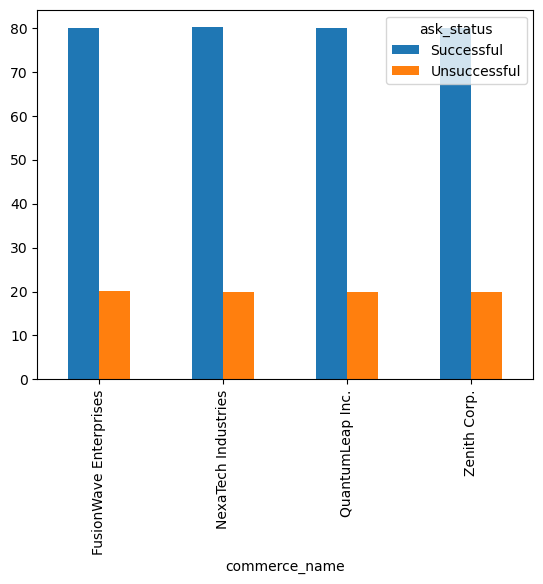

In [9]:
# Tabla de contingencia commerce_id / ask_status
# Grafica los resultados vistos anteriormente en porcentaje
plot= pd.crosstab(index=df["commerce_name"], columns=df["ask_status"]).apply(lambda r:r/r.sum() * 100, axis=1).plot(kind='bar')

## Lógica de las comisiones

In [10]:
# Función para determinar el valor de la comisión según los contratos con cada comercio

def calcular_cobro(total_casos,casos_exitosos, casos_no_exitosos, comercio):
    cobro = 0

    if comercio == "Innovexa Solutions":
         # Regla generar para Innovexa Solutions: $600 por cada caso exitoso
        cobro = casos_exitosos * 300
    
    if comercio == "NexaTech Industries":
        # Regla general para NexaTech Industries
        if total_casos <= 10000:
            cobro = casos_exitosos * 250  # $250 por cada caso exitoso hasta 10,000
        elif total_casos <= 20000:
            cobro = casos_exitosos * 200  # $200 por cada caso exitoso entre 10,001 y 20,000
        else:
            cobro = casos_exitosos * 170  # $170 por cada caso exitoso de más de 20,000

    elif comercio == "QuantumLeap Inc.":
        # Regla especial para QuantumLeap Inc.: $600 por cada caso exitoso
        cobro = casos_exitosos * 600

    elif comercio == "Zenith Corp.":
        # Regla especial para Zenith Corp
        if total_casos <= 22000:
            cobro = casos_exitosos * 250  # $250 por cada caso exitoso hasta 22,000 peticiones realizadas
        else:
            cobro = casos_exitosos * 130  # $130 por cada caso exitoso de más de 22,000 peticiones realizadas
        
        # Si hay más de 6,000 peticiones no exitosas, aplicar un descuento del 5%
        if casos_no_exitosos > 6000:
            cobro *= 0.95  # Aplicar un 5% de descuento

    elif comercio == "FusionWave Enterprises":
        # Regla especial para FusionWave Enterprises
        cobro = casos_exitosos * 300  # $300 por cada caso exitoso
        
        # Descuentos según el número de peticiones no exitosas
        if casos_no_exitosos >= 2500 and casos_no_exitosos <= 4500:
            cobro *= 0.95  # 5% de descuento
        elif casos_no_exitosos > 4500:
            cobro *= 0.92  # 8% de descuento

    return cobro

## Valor total por comercio

In [11]:
# Crear un diccionario para guardar los resultados
resultados = {}

# Iterar sobre los comercios únicos
for comercio in df['commerce_name'].unique():
    # Filtrar el DataFrame por comercio
    df_comercio = df[df['commerce_name'] == comercio]
    
    # Crear un diccionario para almacenar los casos por año-mes
    comercio_resultados = {}
    
    # Agrupar por año, mes y ask_status, y calcular el total de las peticiones y los peticiones exitosos
    for (año, mes), grupo in df_comercio.groupby(['año', 'mes']):
        total_casos = len(grupo)
        casos_exitosos = (grupo['ask_status'] == 'Successful').sum()  # Contar las peticiones exitosas
        casos_no_exitosos = (grupo['ask_status'] != 'Successful').sum()  # Contar los peticiones no exitosos
        porcentaje_exitosos = (casos_exitosos / total_casos) * 100  # Calcular el porcentaje de peticiones exitosas
        
        # Calcular el cobro según las peticiones totales, exitosas y no exitosas
        cobro = calcular_cobro(total_casos,casos_exitosos, casos_no_exitosos, comercio)
        
        # Guardar el resultado en el diccionario
        comercio_resultados[(año, mes)] = {
            'total_casos': total_casos,
            'casos_exitosos': casos_exitosos,
            'casos_no_exitosos': casos_no_exitosos,
            'porcentaje_exitosos': porcentaje_exitosos,
            'cobro': cobro
        }
    
    # Guardar los resultados del comercio
    resultados[comercio] = comercio_resultados

# Crear una lista vacía para almacenar los resultados
resultados_lista = []

# Iterar sobre los resultados para agregar la información a la lista
for comercio, resultado in resultados.items():
    for (año, mes), datos in resultado.items():
        año_mes = f"{año}-{str(mes).zfill(2)}"
        iva=0.19
        iva_calculo=1.19
        # Crear un diccionario para cada fila de resultados
        resultado_fila = {
            'Fecha-Mes': año_mes,
            'Nombre': comercio,
            'Total Casos': datos['total_casos'],
            'Casos Exitosos': datos['casos_exitosos'],
            'Casos No Exitosos': datos['casos_no_exitosos'],
            'Porcentaje Exitosos': datos['porcentaje_exitosos'],
            'Valor_comision': datos['cobro'],
            'Valor_iva': iva,
            'Valor_Total': datos['cobro'] * iva_calculo
        }
        # Agregar la fila a la lista de resultados
        resultados_lista.append(resultado_fila)

## Validación resultados

In [12]:
df_resultados = pd.DataFrame(resultados_lista)
df_resultados.head(100)

,Fecha-Mes,Nombre,Total Casos,Casos Exitosos,Casos No Exitosos,Porcentaje Exitosos,Valor_comision,Valor_iva,Valor_Total
0,2024-01,NexaTech Industries,25155,20157,4998,80.131187,3426690.0,0.19,4077761.10
1,2024-02,NexaTech Industries,23505,18768,4737,79.846841,3190560.0,0.19,3796766.40
2,2024-03,NexaTech Industries,25563,20518,5045,80.264445,3488060.0,0.19,4150791.40
3,2024-04,NexaTech Industries,24827,19861,4966,79.997583,3376370.0,0.19,4017880.30
4,2024-05,NexaTech Industries,25445,20352,5093,79.984280,3459840.0,0.19,4117209.60
5,2024-06,NexaTech Industries,24618,19705,4913,80.043058,3349850.0,0.19,3986321.50
6,2024-07,NexaTech Industries,25416,20387,5029,80.213251,3465790.0,0.19,4124290.10
7,2024-08,NexaTech Industries,25388,20358,5030,80.187490,3460860.0,0.19,4118423.40
8,2024-09,NexaTech Industries,24745,19907,4838,80.448575,3384190.0,0.19,4027186.10
9,2024-10,NexaTech Industries,25577,20440,5137,79.915549,3474800.0,0.19,4135012.00


## Ajuste entregable

In [13]:
# Convertir la lista de resultados en un DataFrame
df_resultados = pd.DataFrame(resultados_lista)

# Agregar el nit y el correo del comercio del dataframe "table_commerce"
df_resultados=pd.merge(df_resultados,table_commerce[['commerce_name', 'commerce_email','commerce_nit']], how="inner", left_on=["Nombre"],right_on=["commerce_name"])

# Renombrar las columnas, según el nombre solicitado
df_resultados=df_resultados.rename(columns={"commerce_email":"Correo","commerce_nit":"Nit"})

# Ordenar los campos según el esquema solicitado
df_resultados=df_resultados[["Fecha-Mes","Nombre","Nit","Valor_comision","Valor_iva","Valor_Total","Correo"]]

df_resultados.to_excel('BATSEJ OPEN FINANCE SA.xlsx',index=False)

# Mostrar el DataFrame
df_resultados.head(100)

,Fecha-Mes,Nombre,Nit,Valor_comision,Valor_iva,Valor_Total,Correo
0,2024-01,NexaTech Industries,452680670,3426690.0,0.19,4077761.10,nexatechindustries@gemaily.net
1,2024-02,NexaTech Industries,452680670,3190560.0,0.19,3796766.40,nexatechindustries@gemaily.net
2,2024-03,NexaTech Industries,452680670,3488060.0,0.19,4150791.40,nexatechindustries@gemaily.net
3,2024-04,NexaTech Industries,452680670,3376370.0,0.19,4017880.30,nexatechindustries@gemaily.net
4,2024-05,NexaTech Industries,452680670,3459840.0,0.19,4117209.60,nexatechindustries@gemaily.net
5,2024-06,NexaTech Industries,452680670,3349850.0,0.19,3986321.50,nexatechindustries@gemaily.net
6,2024-07,NexaTech Industries,452680670,3465790.0,0.19,4124290.10,nexatechindustries@gemaily.net
7,2024-08,NexaTech Industries,452680670,3460860.0,0.19,4118423.40,nexatechindustries@gemaily.net
8,2024-09,NexaTech Industries,452680670,3384190.0,0.19,4027186.10,nexatechindustries@gemaily.net
9,2024-10,NexaTech Industries,452680670,3474800.0,0.19,4135012.00,nexatechindustries@gemaily.net
